In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import DateType
import matplotlib.pyplot as plt
import matplotlib.ticker as tick


In [2]:
spark=SparkSession.builder.appName("Project").getOrCreate()

In [3]:
df=spark.read.csv('hotel_bookings.csv', sep =',', header = True,inferSchema=True)

# Data Semantics

In [4]:
df.printSchema()

root
 |-- hotel: string (nullable = true)
 |-- is_canceled: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_date_year: integer (nullable = true)
 |-- arrival_date_month: string (nullable = true)
 |-- arrival_date_week_number: integer (nullable = true)
 |-- arrival_date_day_of_month: integer (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- adults: integer (nullable = true)
 |-- children: string (nullable = true)
 |-- babies: integer (nullable = true)
 |-- meal: string (nullable = true)
 |-- country: string (nullable = true)
 |-- market_segment: string (nullable = true)
 |-- distribution_channel: string (nullable = true)
 |-- is_repeated_guest: integer (nullable = true)
 |-- previous_cancellations: integer (nullable = true)
 |-- previous_bookings_not_canceled: integer (nullable = true)
 |-- reserved_room_type: string (nullable = true)
 |-- assigned_room_type: string (nullab

In [5]:
df.count()

119390

# Data Cleaning

In [6]:
#Kiểm tra data có duplicates không.
df.distinct().count()

87396

In [7]:
#Kết quả cho thấy chỉ còn 87396 so với 119390. Data đã bị duplicated. Tiến hành xóa
df=df.drop_duplicates()
df.count()

87396

In [8]:
#Kiểm có Null ở các cột
Col_Null={col:df.filter(upper(df[col]).contains('NULL')).count() for col in df.columns}

In [8]:
Col_Null={col:df.filter(upper(df[col]).contains('NULL') | df[col].contains('NA')).count() for col in df.columns}
Col_Null

{'hotel': 0,
 'is_canceled': 0,
 'lead_time': 0,
 'arrival_date_year': 0,
 'arrival_date_month': 0,
 'arrival_date_week_number': 0,
 'arrival_date_day_of_month': 0,
 'stays_in_weekend_nights': 0,
 'stays_in_week_nights': 0,
 'adults': 0,
 'children': 4,
 'babies': 0,
 'meal': 0,
 'country': 455,
 'market_segment': 0,
 'distribution_channel': 0,
 'is_repeated_guest': 0,
 'previous_cancellations': 0,
 'previous_bookings_not_canceled': 0,
 'reserved_room_type': 0,
 'assigned_room_type': 0,
 'booking_changes': 0,
 'deposit_type': 0,
 'agent': 12193,
 'company': 82137,
 'days_in_waiting_list': 0,
 'customer_type': 0,
 'adr': 0,
 'required_car_parking_spaces': 0,
 'total_of_special_requests': 0,
 'reservation_status': 0,
 'reservation_status_date': 0}

In [9]:
#Ta thấy cột company và cột agent chứa rất nhiều giá trị NULL tuy nhiên việc đặt phòng qua công ty hoặc đại lý nào ít ảnh 
#hưởng đến quyết định hủy phòng của khách hàng nên ta bỏ luôn hai cột này
drop_column = ['company','agent']
for col in drop_column:
    df = df.drop(col)

In [10]:
#Cột country chứa 452 giá trị NULL có thể chuyển nó thành 'Unknown' , tuy nhiên ta nên bỏ luôn cột này vì trên thực tế yếu tố địa lý cũng rất 
#ít ảnh hưởng đến quyết định hủy phòng.
df=df.drop('country')

In [11]:
#Xóa giá trị null ở cột children
df = df.where(df.children!='NA')
df.groupBy('children').count().show()

+--------+-----+
|children|count|
+--------+-----+
|       3|   75|
|       0|79028|
|       1| 4695|
|      10|    1|
|       2| 3593|
+--------+-----+



In [12]:
df.columns

['hotel',
 'is_canceled',
 'lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'meal',
 'market_segment',
 'distribution_channel',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'reserved_room_type',
 'assigned_room_type',
 'booking_changes',
 'deposit_type',
 'days_in_waiting_list',
 'customer_type',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'reservation_status',
 'reservation_status_date']

In [14]:
#Kiểm tra lại các giá trị NULL
Col_Null={col:df.filter(upper(df[col]).contains('NULL') | df[col].contains('NA')).count() for col in df.columns}
Col_Null

{'hotel': 0,
 'is_canceled': 0,
 'lead_time': 0,
 'arrival_date_year': 0,
 'arrival_date_month': 0,
 'arrival_date_week_number': 0,
 'arrival_date_day_of_month': 0,
 'stays_in_weekend_nights': 0,
 'stays_in_week_nights': 0,
 'adults': 0,
 'children': 0,
 'babies': 0,
 'meal': 0,
 'market_segment': 0,
 'distribution_channel': 0,
 'is_repeated_guest': 0,
 'previous_cancellations': 0,
 'previous_bookings_not_canceled': 0,
 'reserved_room_type': 0,
 'assigned_room_type': 0,
 'booking_changes': 0,
 'deposit_type': 0,
 'days_in_waiting_list': 0,
 'customer_type': 0,
 'adr': 0,
 'required_car_parking_spaces': 0,
 'total_of_special_requests': 0,
 'reservation_status': 0,
 'reservation_status_date': 0}

In [15]:
from pyspark.sql.functions import regexp_replace

#ở cột meal có một số giá trị là "Undefined" chưa được chuyển đổi thành "SC" theo mô tả ở dataset
df=df.withColumn('meal', regexp_replace('meal', 'Undefined', 'SC'))
df.groupBy('meal').count().show()

+----+-----+
|meal|count|
+----+-----+
|  SC| 9973|
|  FB|  360|
|  BB|67974|
|  HB| 9085|
+----+-----+



In [16]:
#ở cột market_segment có một số giá trị là "Undefined"  được chuyển đổi thành "Online TA" (chọn giá trị xuất hiện nhiều nhất)
df=df.withColumn('market_segment', regexp_replace('market_segment', 'Undefined', 'Online TA'))
df.groupBy('market_segment').count().show()

+--------------+-----+
|market_segment|count|
+--------------+-----+
| Offline TA/TO|13889|
| Complementary|  702|
|      Aviation|  227|
|        Direct|11803|
|     Corporate| 4212|
|     Online TA|51617|
|        Groups| 4942|
+--------------+-----+



In [17]:
#ở cột distribution_chanel có một số giá trị là "Undefined"  được chuyển đổi thành "TA/TO"  (chọn giá trị xuất hiện nhiều nhất)
df=df.withColumn('distribution_channel', regexp_replace('distribution_channel', 'Undefined', 'TA/TO'))
df.groupBy('distribution_channel').count().show()

+--------------------+-----+
|distribution_channel|count|
+--------------------+-----+
|               TA/TO|69142|
|              Direct|12988|
|                 GDS|  181|
|           Corporate| 5081|
+--------------------+-----+



In [18]:
#một số hàng chứa 0 adults, 0 children and 0 babies, ta nên loại bỏ một số hàng này vì nó có thể được xem là nhiễu
#đếm số hàng cả 3 giá trị đều bằng 0
df.filter((df.adults==0) & (df.children==0) & (df.babies==0)).count()

166

In [19]:
#Loại bỏ tất cả hàng có 3 giá trị đều bằng 0 
df = df.where((df.adults!=0) | (df.children!=0) | (df.babies!=0))

In [20]:
df.count()

87226

Sửa đổi kiểu dữ liệu

In [21]:
from pyspark.sql.types import *

In [22]:
#Thuộc tính children nên chuyển về kiểu dữ liệu int
df = df.withColumn('children',df['children'].cast(IntegerType()))
#Thuộc tính reservation_status_date nên chuyển về kiểu dữ liệu date
df = df.withColumn('reservation_status_date',df['reservation_status_date'].cast(DateType()))

In [23]:
df.printSchema()

root
 |-- hotel: string (nullable = true)
 |-- is_canceled: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_date_year: integer (nullable = true)
 |-- arrival_date_month: string (nullable = true)
 |-- arrival_date_week_number: integer (nullable = true)
 |-- arrival_date_day_of_month: integer (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- adults: integer (nullable = true)
 |-- children: integer (nullable = true)
 |-- babies: integer (nullable = true)
 |-- meal: string (nullable = true)
 |-- market_segment: string (nullable = true)
 |-- distribution_channel: string (nullable = true)
 |-- is_repeated_guest: integer (nullable = true)
 |-- previous_cancellations: integer (nullable = true)
 |-- previous_bookings_not_canceled: integer (nullable = true)
 |-- reserved_room_type: string (nullable = true)
 |-- assigned_room_type: string (nullable = true)
 |-- booking_changes: integ

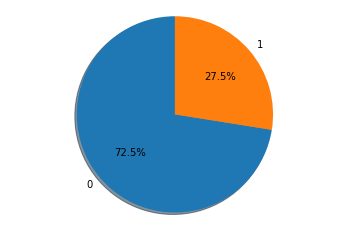

In [24]:
total_count=df.count()
# 1 là hủy, 0 là không!
label=['0','1']
percentages=map(lambda label: df.where('is_canceled ="{}"'.format(label)).count()/total_count,label)
percentages=list(percentages)
fig,ax=plt.subplots()
ax.pie(percentages,labels=label,autopct='%1.1f%%',shadow=True,startangle=90)
ax.axis('equal')
plt.show()
#Con số hủy phòng khá cao. Chiếm đến 27,5%

<AxesSubplot:xlabel='is_canceled', ylabel='days_in_waiting_list'>

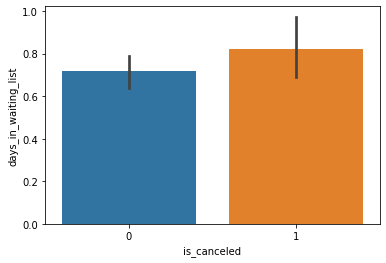

In [25]:
#Biểu diễu ngày đợi của khách hàng
import seaborn as sns
sns.barplot(x = "is_canceled", y = "days_in_waiting_list",data = df.toPandas())

<AxesSubplot:title={'center':'Count of deposit type'}, xlabel='deposit_type', ylabel='count'>

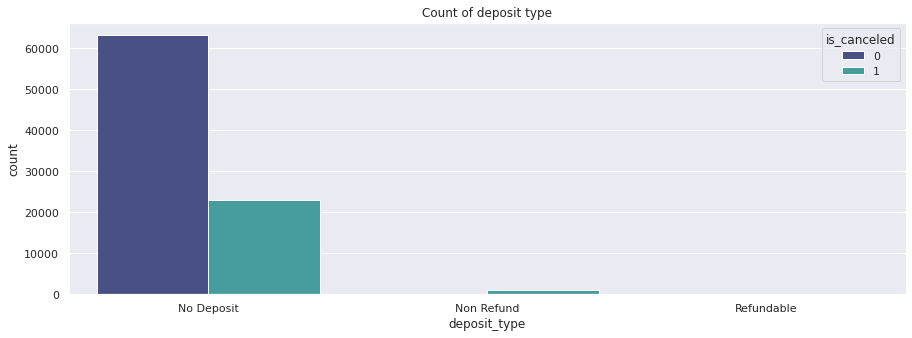

In [26]:
import calendar
sns.set(style = "darkgrid")
plt.figure(figsize=(15, 5));
plt.title("Count of deposit type")
sns.countplot(x='deposit_type', hue='is_canceled', palette="mako",data = df.toPandas())

<AxesSubplot:title={'center':'Count of require car'}, xlabel='required_car_parking_spaces', ylabel='count'>

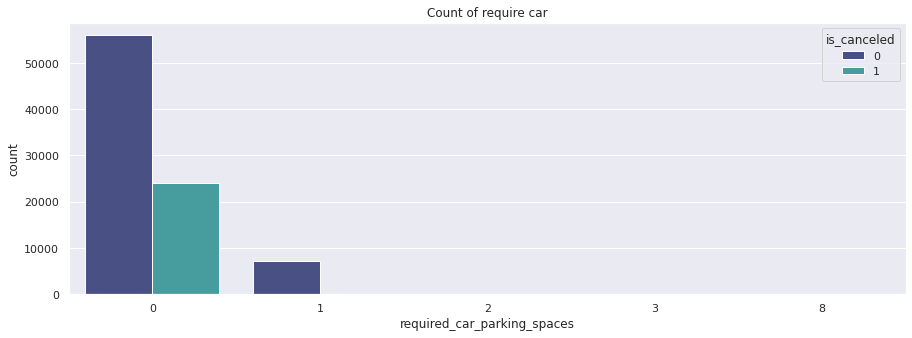

In [27]:
import calendar
sns.set(style = "darkgrid")
plt.figure(figsize=(15, 5));
plt.title("Count of require car")
sns.countplot(x='required_car_parking_spaces', hue='is_canceled', palette="mako",data = df.toPandas())

Sau khi làm sạch dữ liệu , chúng ta còn lại 87226 row x 32 column so với ban đầu là 119390 x 32 

# FEATURE SELECTION

Đối với bài toán này ta cần lựa chọn các feature có đóng góp ý nghĩa đối với việc hủy phòng và loại bỏ các feature còn lại để
giảm bớt độ phức tạp cho mô hình

- Hotel: Phân tích biểu đồ tỉ lệ phần trăm hủy bỏ đối mỗi tháng của 2 loại khách sạn sẽ thấy sự khác nhau khi loại resort sẽ bị hủy nhiều hơn vào mùa hè chứng tỏ hai thuộc tính hotel và arrival_date_month cùng tác động đến tỉ lệ canceled (chưa vẽ được biểu đồ)
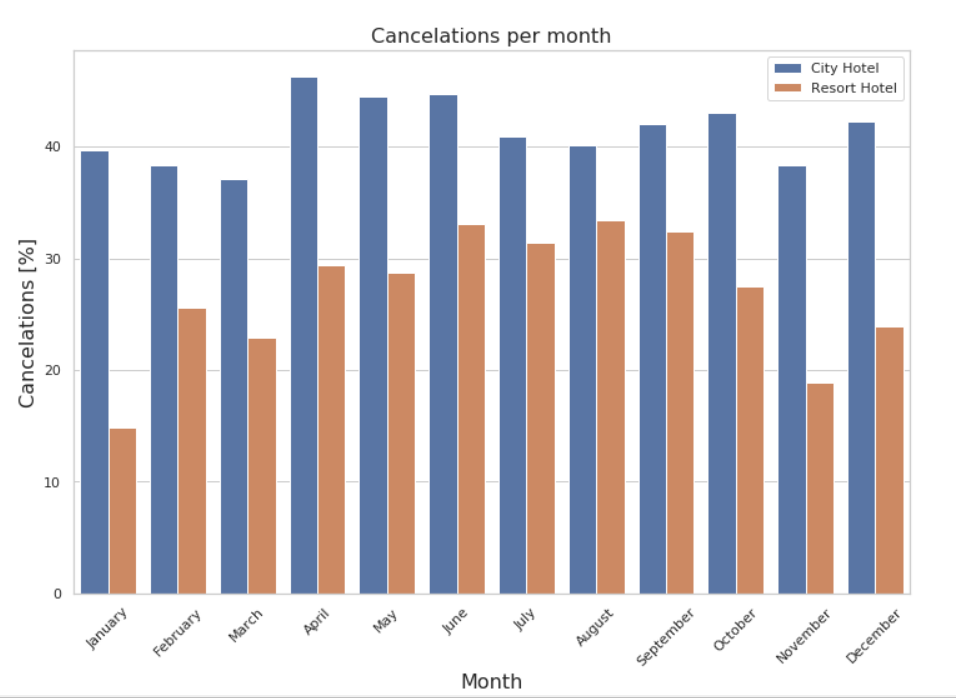



- lead_time: ta có thể nhận thấy rằng trong thực tế những người đặt khách sạn càng gần thời gian đến sẽ có xu hướng khó hủy hơn so với những người đặt từ lâu. Điều này là hợp lí nên lead_time cũng được chọn
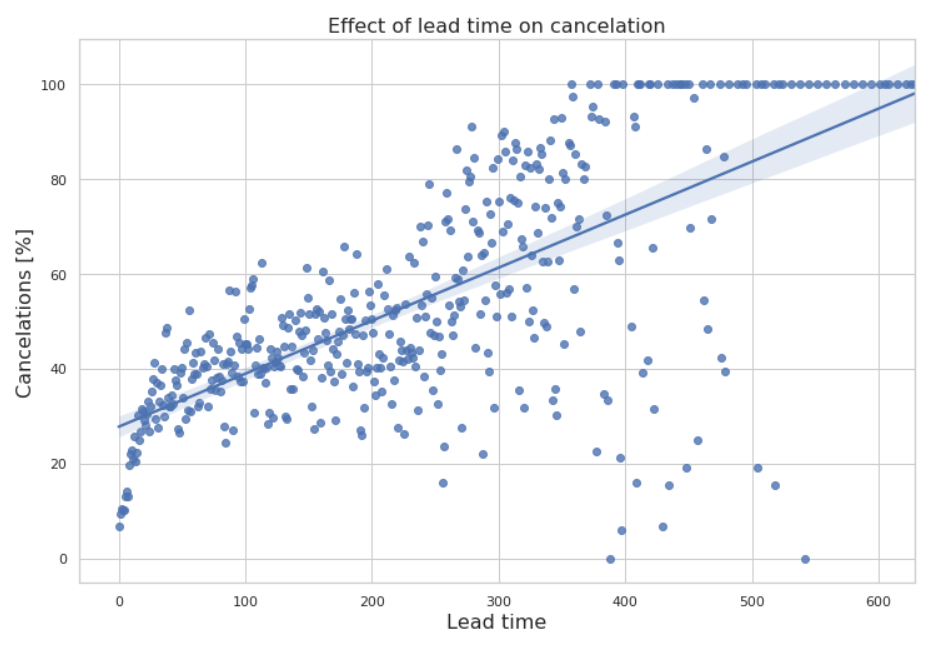

- arrival_date_year, arrival_date_month, arrival_date_week_number, arrival_date_day_of_month: Các yếu tố về thời gian
    + arrival_date_month: như đã phân tích ở thuộc tính hotel (chọn)
    + arrival_date_year: mỗi năm lại có những biến cố thay đổi khác nhau nên ta không sử dụng thuộc tính này (loại)
    + arrival_date_week_number: thuộc tính có thể xem là tương đương với arrival_date_month nên ta có thể loại (loại)
    + arrival_date_day_of_month: với thuộc tính này ta cũng không thể quyết định được liệu khách hàng có hủy phòng hay không.(loại)
- stays_in_weekend_nights: những đơn đặt phòng càng rơi nhiều vào những ngày cuối tuần thì xác suất hủy phòng có thể thấp hơn vì cuối tuần chúng ta thường đi chơi, thư giãn, ít bận bịu công việc => chọn
- stays_in_week_nights: những đơn đặt phòng càng rơi nhiều vào những làm việc trong tuần thì xác suất hủy phòng có thể tăng lên => chọn
- adults, children, babies: Ta có thể thấy rằng trong thực tế những nhóm người càng có nhiều người và có nhiều children và babies hơn thì xác suất hủy phòng cao hơn vì dễ xảy ra biến cố (bận việc, đau ốm,...) nên ta có thể chọn cả 3 thuộc tính này
- meal: việc đặt trước ăn,loại thức ăn cũng phần nào đó thể hiện tầm quan trọng của đơn đặt phòng => tính đảm bảo của việc không hủy phòng cho nên ta giữ lại thuộc tính này
- market_segment, distribution_channel: đây là các thuộc tính về hình thức đặt phòng. Mỗi hình thức đặt phòng cũng sẽ phản ánh một tỉ lệ hủy phòng khác nhau. Ví dụ: đặt phòng dạng doanh nghiệp hoặc tour du lịch sẽ khó bị hủy hơn so với đặt phòng cá nhân. vì nó thường có các điều khoản hợp đồng. => chọn
- is_repeated_guest: việc một người có phải là khách hàng cũ không ảnh hưởng đến việc hủy phòng. Loại.
- previous_cancellation: thuộc tính này có thể giúp xác định khách hàng có phải spam hay không nên ta có thể chọn.
- previous_bookings_not_canceled: thuộc tính này giúp xác định uy tín của khách hàng, ta có thể chọn.
- reserved_room_type, assigned_room_type: Đat : thuộc tính loại phòng không thể hiện được điều gì, ta bỏ chọn 2 thuộc tính này. 
- booking_changes: Đạt những khách hàng sửa đổi càng nhiều có xu hướng quan tâm đến việc đặt phòng của mình nhiều hơn, do vậy đơn đặt phòng sẽ khó bị hủy hơn => chọn
- deposit_type: loại thanh toán không thể hiện được điều gì . Thể hiện ở visualize => loại!!!!!!!!! 
- days_in_waiting_list: Đạt: thuộc tính này có thể phản ánh được chất lượng phục vụ khách hàng => chọn
      Dũng: Thuộc tính thay đổi theo thời gian có nhiều trường hợp.Khiến model không tổng quát được.Dựa vô visual tăng không đáng kể=>>Loại
- customer_type: phản ánh được tính ràng buộc giữa khách hàng và khách sạn đối với việc hủy phòng => chọn
- adr: giá tiền thường đã được khách hàng xem xét kĩ khi quyết định đặt phòng nên thuộc tính này ít ảnh hưởng đến việc hủy phòng => loại
- required_car_parking_spaces:  Đat:nhu cầu về đậu xe ít phản ánh => loại
                             Dũng:Biểu đồ visua cho thấy sự phản ảnh có liên quan đến chỗ đậu xe.=>> Chọn
- total_of_special_requests: càng nhiều yêu cầu đặc biệt thì tính chất càng quan trọng => chọn
- reservation_status: Đat: nếu trạng thái cuối cùng là canceled thì chắc chắn sẽ bị canceled => chọn
                      Dũng: Đây sẽ là output mà model cố gắng dự đoán.Sẽ gây ra nhiễu ->>> Loại
- reservation_status_date: ngày trạng thái cuối cùng không quan trọng => loại

Tổng kết: 
  - Các thuộc tính được chọn: hotel, leadtime, arrival_date_month, stays_in_weekend_nights, stays_in_week_nights,  adults, children, babie, meal, market_segment, distribution_channel, previous_cancellation, previous_bookings_not_canceled, reserved_room_type,assigned_room_type, booking_changes, days_in_waiting_list, customer_type,  total_of_special_requests,  reservation_status ( 20 thuộc tính)
  - Các thuộc tính bị loại:  arrival_date_year, arrival_date_week_number, arrival_date_day_of_month, is_repeated_guest, deposit_type, adr, required_car_parking_spaces, reservation_status_date,reservation_status (9 thuộc tính)

In [25]:
#Drop columns được cho là không quan trọng
drop_columns = ['arrival_date_year','arrival_date_week_number','arrival_date_day_of_month','is_repeated_guest','deposit_type',
                'adr','reservation_status_date','reservation_status','days_in_waiting_list','booking_changes',
                'assigned_room_type', 'reserved_room_type']

selected_df = df.select('*')
for col in drop_columns:
    selected_df = selected_df.drop(col)

In [26]:
len(selected_df.columns)
#Trước khi chuyển sang one-hot dataset gôm 17 features

17

In [27]:
selected_df.toPandas().head()

,hotel,is_canceled,lead_time,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,market_segment,distribution_channel,previous_cancellations,previous_bookings_not_canceled,customer_type,required_car_parking_spaces,total_of_special_requests
0,Resort Hotel,0,324,July,4,10,2,0,0,HB,Offline TA/TO,TA/TO,0,0,Contract,0,0
1,Resort Hotel,0,30,July,0,1,2,0,0,BB,Offline TA/TO,TA/TO,0,0,Contract,0,0
2,Resort Hotel,1,67,July,0,2,2,0,0,BB,Online TA,TA/TO,0,0,Transient,0,1
3,Resort Hotel,0,89,July,2,5,2,0,0,BB,Offline TA/TO,TA/TO,0,0,Transient,0,1
4,Resort Hotel,0,28,July,1,3,2,0,0,HB,Offline TA/TO,TA/TO,0,0,Transient,0,0


In [28]:
selected_df.printSchema()

root
 |-- hotel: string (nullable = true)
 |-- is_canceled: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_date_month: string (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- adults: integer (nullable = true)
 |-- children: integer (nullable = true)
 |-- babies: integer (nullable = true)
 |-- meal: string (nullable = true)
 |-- market_segment: string (nullable = true)
 |-- distribution_channel: string (nullable = true)
 |-- previous_cancellations: integer (nullable = true)
 |-- previous_bookings_not_canceled: integer (nullable = true)
 |-- customer_type: string (nullable = true)
 |-- required_car_parking_spaces: integer (nullable = true)
 |-- total_of_special_requests: integer (nullable = true)



# DATA ENGINEER

In [29]:
# chuyển đổi biến categorical thành các biến giả / chỉ số.
meal=selected_df.select('meal').distinct().rdd.flatMap(lambda x:x).collect()
market_segment=selected_df.select('market_segment').distinct().rdd.flatMap(lambda x:x).collect()
distribution_channel=selected_df.select('distribution_channel').distinct().rdd.flatMap(lambda x:x).collect()
customer_type=selected_df.select('customer_type').distinct().rdd.flatMap(lambda x:x).collect()
hotel=selected_df.select('hotel').distinct().rdd.flatMap(lambda x:x).collect()


In [30]:
#Convert one hot encoding
import pyspark.sql.functions as F
convert_meal = [F.when(F.col("meal") == x, 1).otherwise(0).alias("meal_" + x) for x in meal]
convert_market= [F.when(F.col("market_segment") == x, 1).otherwise(0).alias("market_segment_" + x) for x in market_segment]
convert_channel = [F.when(F.col("distribution_channel") == x, 1).otherwise(0).alias("distribution_channel_" + x) for x in distribution_channel]
convert_custype = [F.when(F.col("customer_type") == x, 1).otherwise(0).alias("customer_type_" + x) for x in customer_type]
convert_hotel = [F.when(F.col("hotel") == x, 1).otherwise(0).alias("hotel_" + x) for x in hotel]

In [31]:
data = selected_df.select(
 'is_canceled',
 'lead_time',
 'arrival_date_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'required_car_parking_spaces',
 'total_of_special_requests', *convert_meal+convert_market+convert_channel+convert_custype+convert_hotel)

In [32]:
#Chuyển tháng từ categrocial thành numeric
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf, struct,col
month_dict={'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6,'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12 }
#Convert Month qua số để chạy model
user_func =  udf (lambda x: month_dict[x])
data=data.withColumn('arrival_date_month',user_func(col('arrival_date_month')))
#Cast tháng sang integer (1->12)
data = data.withColumn('arrival_date_month',data['arrival_date_month'].cast(IntegerType()))

Min-max scaler cho numeric features

In [33]:
numeric_features = ['lead_time',
                    'arrival_date_month',
                    'stays_in_weekend_nights',
                    'stays_in_week_nights',
                    'adults',
                    'children',
                    'babies',
                    'total_of_special_requests',
                    'required_car_parking_spaces']

numeric_summary = data.select(numeric_features).describe().toPandas().transpose()

In [34]:
numeric_summary

,0,1,2,3,4
summary,count,mean,stddev,min,max
lead_time,87226,79.97454887304244,86.05907557239316,0,737
arrival_date_month,87226,6.4748354848325045,3.0965309668301035,1,12
stays_in_weekend_nights,87226,1.004620182055809,1.0274151928056778,0,19
stays_in_week_nights,87226,2.623942402494669,2.0398398227727497,0,50
adults,87226,1.8793479008552496,0.6217262307271681,0,55
children,87226,0.13890353793593654,0.4562743028387541,0,10
babies,87226,0.010845390135968634,0.11370617582912482,0,10
total_of_special_requests,87226,0.6989085823034417,0.8320564784570431,0,5
required_car_parking_spaces,87226,0.08430972416481325,0.2816645093489636,0,8


In [35]:
from pyspark import SparkContext
sc = SparkContext.getOrCreate()
sc.broadcast(numeric_summary)

In [36]:
#Lọc ra các numeric features
numeric_df = data.select(numeric_features)

In [37]:
#Tính min-max scaler : (x - min)/ (max - min)
rdd1 = numeric_df.rdd.map(list).map(lambda x: list(float(x[i]-float(numeric_summary[3][i+1]))/float(float(numeric_summary[4][i+1])-float(numeric_summary[3][i+1])) 
                                                               for i in range(len(x))))

#chuyển thành dataframe
numeric_df = rdd1.toDF(numeric_features)

# Đổi tên cho columns
cols = numeric_df.columns
for i in range(len(numeric_df.columns)):
    numeric_df=numeric_df.withColumnRenamed(numeric_df.columns[i],cols[i])

In [38]:
numeric_df

DataFrame[lead_time: double, arrival_date_month: double, stays_in_weekend_nights: double, stays_in_week_nights: double, adults: double, children: double, babies: double, total_of_special_requests: double, required_car_parking_spaces: double]

In [39]:
ori_data = data.select('is_canceled',
 'meal_SC',
 'meal_FB',
 'meal_BB',
 'meal_HB',
 'market_segment_Offline TA/TO',
 'market_segment_Complementary',
 'market_segment_Aviation',
 'market_segment_Direct',
 'market_segment_Corporate',
 'market_segment_Online TA',
 'market_segment_Groups',
 'distribution_channel_TA/TO',
 'distribution_channel_Direct',
 'distribution_channel_GDS',
 'distribution_channel_Corporate',
 'customer_type_Transient',
 'customer_type_Transient-Party',
 'customer_type_Group',
 'customer_type_Contract',
 'hotel_City Hotel',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'hotel_Resort Hotel')

from pyspark.sql.functions import monotonically_increasing_id

DF1 = ori_data.withColumn("row_id", monotonically_increasing_id())
DF2 = numeric_df.withColumn("row_id", monotonically_increasing_id())
result_df = DF1.join(DF2, ("row_id")).drop("row_id")

In [40]:
#Thêm bias 
from pyspark.sql.functions import lit
result_df = result_df.withColumn("bias",lit(1.0))

In [41]:
result_df.toPandas().head()

,is_canceled,meal_SC,meal_FB,meal_BB,meal_HB,market_segment_Offline TA/TO,market_segment_Complementary,market_segment_Aviation,market_segment_Direct,market_segment_Corporate,...,lead_time,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,total_of_special_requests,required_car_parking_spaces,bias
0,0,0,0,0,1,1,0,0,0,0,...,0.439620,0.545455,0.210526,0.20,0.036364,0.0,0.0,0.0,0.0,1.0
1,0,0,0,1,0,1,0,0,0,0,...,0.040706,0.545455,0.000000,0.02,0.036364,0.0,0.0,0.0,0.0,1.0
2,1,0,0,1,0,0,0,0,0,0,...,0.090909,0.545455,0.000000,0.04,0.036364,0.0,0.0,0.2,0.0,1.0
3,0,0,0,1,0,1,0,0,0,0,...,0.120760,0.545455,0.105263,0.10,0.036364,0.0,0.0,0.2,0.0,1.0
4,0,0,0,0,1,1,0,0,0,0,...,0.037992,0.545455,0.052632,0.06,0.036364,0.0,0.0,0.0,0.0,1.0


In [42]:
#save lại file pandas
result_df.toPandas().to_csv('./engineered_df.csv',index=False)

# Thuật toán Logistics regression

In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import DateType
import matplotlib.pyplot as plt
import matplotlib.ticker as tick

spark=SparkSession.builder.appName("Project").getOrCreate()

In [2]:
#load file csv đã engineer
result_df = spark.read.csv('engineered_df.csv', sep =',', header = True,inferSchema=True)

In [4]:
#Chia tập train,test tỉ lệ 8:2
training, test = result_df.randomSplit([0.8, 0.2])

In [5]:
result_df.groupBy('is_canceled').count().show()

+-----------+-----+
|is_canceled|count|
+-----------+-----+
|          1|24005|
|          0|63221|
+-----------+-----+



In [6]:
training.count()

69760

In [7]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

In [8]:
# Cross Entropy - dùng để kiểm tra quá trình map reduce
def compute_cost(X,theta,m):
    tol = 1e-9
    # zi, yi
    rdd1 = X.map(lambda p:(sigmoid(np.dot(np.array(p[0]),np.array(theta))),p[1]))
    # ji(w)
    rdd2 = rdd1.map(lambda p: (p[1]*np.log(p[0] if p[0]>tol else tol)+(1-p[1])*np.log(1-p[0] if 1-p[0]>tol else tol)))
    # j(w)
    j = -rdd2.reduce(lambda x,y:x+y)/m
    return j

In [9]:
# theta là vetor w cần tìm
# alpha hằng số learning_rate
# num_inters số vòng lặp - ko có điều dừng
def gradient_descent(X_train, X_test, theta, alpha, num_inters):
    # m_train là số lượng điểm dữ liệu của tập train
    m_train = X_train.count()
    # m_test là số lượng điểm dữ liệu của tập test
    m_test = X_test.count()
    # train_costs và test_costs là hai mảng để lưu lại giá trị compute_cost() trong quá trình train và test
    train_costs = [float('inf')]
    test_costs = [float('inf')]
    # thetas là mảng lưu giá trị các trọng số được cập nhật
    thetas = [theta]

    count = 0
    # check_w_after là số vòng lặp sẽ kiểm tra thay đổi
    check_w_after = 20
    # khoảng cách tối thiểu
    distance = 1e-5
    # v_old là giá trị velocity cũ trong Momentum Gradient Descent
    v_old = np.zeros_like(theta)

    while count<num_inters:
        # delta là giá trị đạo hàm của w theo cost
        delta = X_train.map(lambda p: np.array(p[0])*(sigmoid(np.dot(np.array(p[0]),theta))-p[1])).reduce(lambda x, y: x+y)
        theta = theta - alpha* delta/m_train
        # tính giá trị cost với theta mới
        train_cost = compute_cost(X_train,theta,m_train)
        test_cost = compute_cost(X_test,theta,m_test)
        
        
        train_costs.append(train_cost) 
        test_costs.append(test_cost)
        thetas.append(theta)
        
        count+=1
       
        if count%check_w_after == 0:
            # nếu test_cost không thay đổi dưới 1e-5 thì dừng lại
            # khoảng cách giữa 2 giá trị test_cost[count-1], test_costs[-check_w_after+1]
            # e.g: 
            # count = 20: test_costs[19], test_costs[-19] 
            # count = 40: test_costs[39], test_costs[-19]
            if test_costs[-check_w_after] - test_costs[count]  < distance:
                print('Early Stopping at epoch: ',count)
                return train_costs[1:len(train_costs)],test_costs[1:len(test_costs)],thetas[-1]
    
        print('Epoch:',count,' ','Train_cost:',train_cost,' ','Test_cost:',test_cost)

    return train_costs[1:len(train_costs)], test_costs[1:len(test_costs)], thetas[-1]

In [10]:
def predict(X,theta):
    prob = sigmoid(np.dot(X, theta))
    return 1 if prob>=0.5 else 0

In [11]:
def score(X,theta):
    rdd_kq = X.map(lambda x: (x[0],sigmoid(np.dot(np.array(x[1:len(x)]),theta))))
    rdd_kq = rdd_kq.map(lambda x: (x[0],1 if x[1]>=0.5 else 0))
    
    tp = rdd_kq.map(lambda x: 1 if (x[0] == 0 and x[1]==0) else 0).reduce(lambda a,b: a+b)
    fp = rdd_kq.map(lambda x: 1 if (x[0] == 1 and x[1]==0) else 0).reduce(lambda a,b: a+b)
    fn = rdd_kq.map(lambda x: 1 if (x[0] == 0 and x[1]==1) else 0).reduce(lambda a,b: a+b)
    tn = rdd_kq.map(lambda x: 1 if (x[0] == 1 and x[1]==1) else 0).reduce(lambda a,b: a+b)
    print (' True Positive : {0}'.format(tp))
    print (' False Positive : {0}'.format(fp))
    print (' False Negative : {0}'.format(fn))
    print (' True Negative : {0}'.format(tn))
    lo_cm = np.array([[tp,fn],[fp,tn]])
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = 2*precision*recall/(precision+recall)
    return lo_cm, precision, recall, f1_score

In [27]:
def gradient_descent_with_momentum(X_train,X_test,theta, alpha, gamma, num_inters):
    #m_train là số lượng điểm dữ liệu của tập train
    m_train = X_train.count()
    #m_test là số lượng điểm dữ liệu của tập test
    m_test = X_test.count()
    #train_costs và test_costs là hai mảng để lưu lại giá trị cost trong quá trình train và test
    train_costs = [float('inf')]
    test_costs = [float('inf')]
    #thetas là mảng lưu giá trị các trọng số được cập nhật
    thetas = [theta]
    
    count = 0
    
    #khoảng cách tối thiểu
    distance = 1e-5
    
    #check_w_after là số vòng lặp mà test_cost sẽ được check lại
    check_w_after = 20
    #v_old là giá trị velocity cũ trong Momentum Gradient Descent
    v_old = np.zeros_like(theta)

    while count<num_inters:
        #delta là giá trị đạo hàm của w theo cost
        delta = X_train.map(lambda p: np.array(p[0])*(sigmoid(np.dot(np.array(p[0]),theta))-p[1])).reduce(lambda x, y: x+y)
        #cập nhật lại velocity mới
        v_new = gamma * v_old + alpha* delta/m_train
        #cập nhật lại theta
        theta = theta - v_new
        v_old = v_new
        #tính giá trị cost với theta mới
        train_cost = compute_cost(X_train,theta,m_train)
        test_cost = compute_cost(X_test,theta,m_test)
        
        #thêm các giá trị cost và theta vào mảng lưu giá trị
        train_costs.append(train_cost) 
        test_costs.append(test_cost)
        thetas.append(theta)
        count+=1
        
        if count%check_w_after==0:
            #nếu test_cost không thay đổi dưới 1e-4 thì dừng lại
            if test_costs[-check_w_after] - test_costs[count]  < distance:
                print(test_costs[count-1],test_costs[-check_w_after+1])
                print('Early Stopping at epoch: ',count)
                return train_costs[1:len(train_costs)],test_costs[1:len(test_costs)],thetas[-1]
     
        print('Epoch:',count,' ','Train_cost:',train_cost,' ','Test_cost:',test_cost)

    return train_costs[1:len(train_costs)],test_costs[1:len(test_costs)],thetas[-1]

In [28]:
import time
import pandas as pd
import numpy as np

#Xavier Initialization : theta = np.random.randn(n-1) * np.sqrt(2/(n-1)) với n là số feature

theta = np.random.randn(len(training.columns)-1) * np.sqrt(2/(len(training.columns)-1))
alpha = 0.5
gamma = 0.9

start_time = time.time()

data1 = training.rdd.map(list).map(lambda p: (p[1:len(p)],p[0]))
data2 = test.rdd.map(list).map(lambda p: (p[1:len(p)],p[0]))
train_costs,test_costs,theta = gradient_descent_with_momentum(data1,data2,theta,alpha,gamma,5000)
#train_costs,test_costs,theta = gradient_descent(data1,data2,theta,alpha,1000)

end_time = time.time()
print ('Total run-time of logistics regression: %f h' % ((end_time - start_time) /3600 ))

Epoch: 1   Train_cost: 0.6514104432905169   Test_cost: 0.6432537787961253
Epoch: 2   Train_cost: 0.6268320364958873   Test_cost: 0.6195673279936655
Epoch: 3   Train_cost: 0.5998724059805022   Test_cost: 0.5951662043168588
Epoch: 4   Train_cost: 0.5866108617618865   Test_cost: 0.5823060695541372
Epoch: 5   Train_cost: 0.5785505970574819   Test_cost: 0.574279733765774
Epoch: 6   Train_cost: 0.5722812301287565   Test_cost: 0.5686630254324251
Epoch: 7   Train_cost: 0.5687937499734501   Test_cost: 0.565979262078427
Epoch: 8   Train_cost: 0.5666719747102906   Test_cost: 0.5644668368761874
Epoch: 9   Train_cost: 0.5639974316226797   Test_cost: 0.5620553108782265
Epoch: 10   Train_cost: 0.5610562306341047   Test_cost: 0.5590152053340233
Epoch: 11   Train_cost: 0.5592115489106609   Test_cost: 0.5568923051113741
Epoch: 12   Train_cost: 0.558513599227829   Test_cost: 0.5559702360471046
Epoch: 13   Train_cost: 0.5577542218214302   Test_cost: 0.5551963106817238
Epoch: 14   Train_cost: 0.55626790145

In [30]:
theta

array([ -0.35506649,   0.21269729,  -0.40039274,  -0.3406567 ,
        -1.04617117,  -0.03134208,   0.17657974,  -0.17006659,
         0.14582008,   0.5301122 ,   0.10004832,   0.31506656,
        -0.18252489,  -0.43233199,  -0.28969279,   0.67771539,
        -0.39584994,  -0.36521498,  -0.15134865,  -0.49748089,
         1.83827275,  -0.37179515,  -0.59182301,   3.74701549,
         0.03511401,   0.34684823,   2.66155981,   2.61414075,
         2.12824014,   0.27249283,  -3.36602793, -19.39791086,
        -1.21922799])

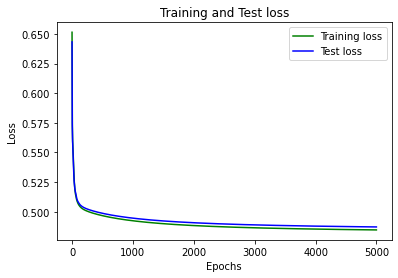

In [29]:
# visualize lost
# so sách giá trị cross entropy giữa 2 tập data_test, data_train sau khi train

import matplotlib.pyplot as plt

loss_train = train_costs
loss_test = test_costs
epochs = range(0,len(loss_train))
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_test, 'b', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [31]:
print("- ĐỘ ĐO ĐÁNH GIÁ TRÊN TẬP TRAINING: ")
lo_cm, precision, recall, f1_score = score(training.rdd,theta)
#print ('Logistics Regression Accuracy Score: {0}'.format(acc))
print ('Precision: {0}'.format(precision))
print ('Recall: {0}'.format(recall))
print ('F1-score: {0}'.format(f1_score))

print("- ĐỘ ĐO ĐÁNH GIÁ TRÊN TẬP TEST: ")
lo_cm, precision, recall, f1_score = score(test.rdd,theta)
#print ('Logistics Regression Accuracy Score: {0}'.format(acc))
print ('Precision: {0}'.format(precision))
print ('Recall: {0}'.format(recall))
print ('F1-score: {0}'.format(f1_score))



- ĐỘ ĐO ĐÁNH GIÁ TRÊN TẬP TRAINING: 
 True Positive : 47252
 False Positive : 12491
 False Negative : 3243
 True Negative : 6774
Precision: 0.7909211120968147
Recall: 0.9357758193880582
F1-score: 0.8572724468876431
- ĐỘ ĐO ĐÁNH GIÁ TRÊN TẬP TEST: 
 True Positive : 11858
 False Positive : 3079
 False Negative : 868
 True Negative : 1661
Precision: 0.7938675771573944
Recall: 0.9317931793179318
F1-score: 0.8573184397932256


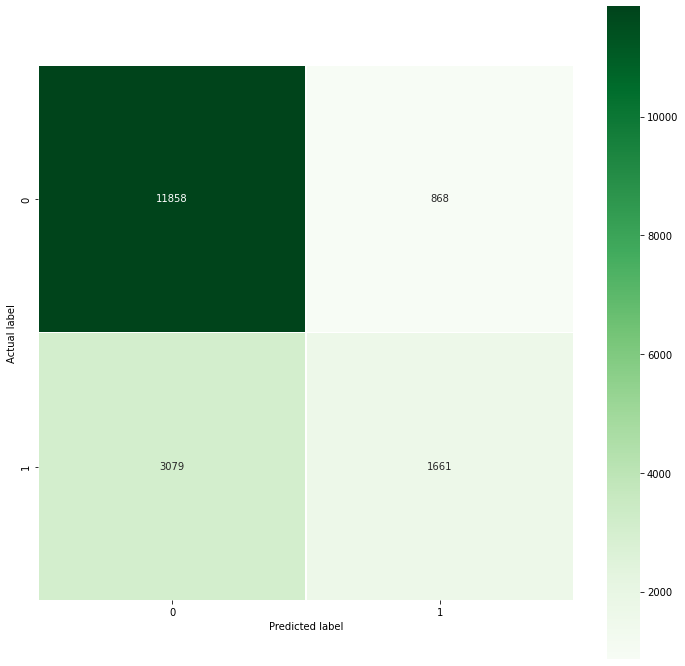

In [32]:
import seaborn as sns 

plt.figure(figsize=(12,12))
sns.heatmap(lo_cm,annot=True,fmt=".0f",linewidths=.5,square=True,cmap='Greens')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'Confusion matrix trên tập test'